# `photoeccentric` Tutorial

In this tutorial, I will create a simulated transit based on a Kepler planet and demonstrate how to use `photoeccentric` to recover the planet's eccentricity using the photoeccentric effect [(Dawson & Johnson 2012)](https://arxiv.org/pdf/1203.5537.pdf).

In [486]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I'll define the conversions between solar mass -> kg and solar radius -> meters for convenience.

In [487]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## The Sample

I'm using the sample of "cool KOIs" from [Muirhead et al. 2013](https://iopscience.iop.org/article/10.1088/0067-0049/213/1/5), and their properites from spectroscopy published here.

In [488]:
muirhead_data = pd.read_csv("/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")


In [508]:
#Kepler planets with spectroscopy
# rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
#spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]

spectplanets = spectplanets.reset_index()

#### Reading Gaia-Kepler data (luminosities)

In [510]:
df = Table.read('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas()

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [511]:
muirhead_gaia = df[df['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

#muirhead_comb: planet hosts with spectroscopic data + Gaia/Kepler data in one table
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# only targets with gaia luminosities
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

In [512]:
muirhead_comb_lums

,KOI,KIC,Teff,ETeff,eTeff,Fe/H,e_Fe/H,M/H,e_M/H,SpType,...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist
0,4290,5868793.0,3187.0,62.0,88.0,0.10,0.16,0.07,0.13,M4V,...,-0.034,b'DSEP',0,1,1,13.594,12.937,12.776,b'cand',0.063243
3,1725B,10905746.0,3253.0,62.0,57.0,0.16,0.13,0.11,0.12,M4V,...,-0.055,b'DSEP',1,1,1,13.671,13.055,12.826,b'conf',0.036267
5,3749,11547869.0,3337.0,121.0,59.0,0.10,0.18,0.07,0.15,M3V,...,-0.044,b'DSEP',0,1,1,13.452,12.774,12.609,b'cand',0.084275
6,249B,9390653.0,3349.0,194.0,47.0,-0.11,0.27,-0.08,0.20,M3V,...,-0.042,b'DSEP',0,1,1,13.480,12.805,12.639,b'cand',0.087092
10,3497,8424002.0,3412.0,61.0,91.0,0.02,0.16,0.01,0.14,M3V,...,-0.064,b'DSEP',0,1,1,13.409,12.758,12.611,b'cand',0.060459
13,2542,6183511.0,3466.0,58.0,85.0,0.10,0.15,0.07,0.14,M2V,...,-0.038,b'DSEP',4,4,4,13.952,13.278,13.116,b'conf',0.080101
14,2705,11453592.0,3494.0,66.0,59.0,0.11,0.14,0.07,0.13,M2V,...,-0.042,b'DSEP',0,1,1,13.339,12.684,12.499,b'cand',0.054480
15,1422,11497958.0,3522.0,59.0,62.0,-0.08,0.13,-0.06,0.13,M2V,...,-0.039,b'DSEP',2,2,2,13.224,12.537,12.312,b'conf',0.083184
16,1146,8351704.0,3560.0,87.0,47.0,-0.18,0.14,-0.13,0.13,M2V,...,-0.044,b'DSEP',1,1,1,13.405,12.723,12.492,b'conf',0.072411
17,1686,6149553.0,3561.0,49.0,97.0,-0.20,0.15,-0.14,0.13,M2V,...,-0.044,b'DSEP',1,2,3,11.951,11.279,11.056,b'conf',0.109478


In [450]:
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

In [451]:
test_planet = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

In [452]:
test_planet.lum_val

0    0.097283
Name: lum_val, dtype: float32

In [489]:
isochrones = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

In [453]:
def fit_isochrone_lum(data, isochrones, gaia_lum=True):
    """
       Inputs:
       data: pd.DataFrame. Spectroscopic data + Kepler/Gaia for n stars in one table. (muirhead_comb)
       isochrones: pd.DataFrame. Isochrones table. (isochrones)
       
       Returns: list of pd.DataFrames. Each element of list is a pd.DataFrame of the isochrones that fit this star (index) BASED ON SPECTROSCOPY AND GAIA LUMINOSITY.
       """    
    
    iso_fits_final = list()
    
    #for i in tqdm(range(len(muirhead_comb))):
    for i in range(1):
        
        iso_fits = pd.DataFrame() 
    
        Teff_range = [float(data.Teff)-float(data.eTeff), float(data.Teff)+float(data.ETeff)]
        Mstar_range = [float(data.Mstar)-float(data.e_Mstar), float(data.Mstar)+float(data.e_Mstar)]
        Rstar_range = [float(data.Rstar)-float(data.e_Rstar), float(data.Rstar)+float(data.e_Rstar)]
        lum_range = [float(data.lum_val)-float(data.lum_percentile_lower), float(data.lum_val)+float(data.lum_percentile_lower)]

        print(Teff_range)
        print(Mstar_range)
        print(Rstar_range)
        print(lum_range)
        
        for j in tqdm(range(len(isochrones))):
            if gaia_lum==True:
                if Teff_range[0] < 10**isochrones.logt[j] < Teff_range[1] and Mstar_range[0] < isochrones.mstar[j] < Mstar_range[1] and Rstar_range[0] < isochrones.radius[j] < Rstar_range[1] and lum_range[0] < 10**isochrones.logl_ls[j] < lum_range[1]:
                    iso_fits = iso_fits.append(isochrones.loc[[j]])
            
            if gaia_lum==False:
                if Teff_range[0] < 10**isochrones.logt[j] < Teff_range[1] and Mstar_range[0] < isochrones.mstar[j] < Mstar_range[1] and Rstar_range[0] < isochrones.radius[j] < Rstar_range[1]:
                    iso_fits = iso_fits.append(isochrones.loc[[j]])
        
        iso_fits['KIC'] = muirhead_comb['KIC'][i]
        iso_fits['KOI'] = muirhead_comb['KOI'][i]
        
        iso_fits_final.append(iso_fits)
            
    return iso_fits_final

In [454]:
iso_lums = fit_isochrone_lum(test_planet, isochrones)

  0%|          | 2518/738479 [00:00<00:29, 25160.35it/s]

[3099.0, 3249.0]
[0.13999999999999999, 0.22]
[0.17, 0.23]
[0.0034218057990074158, 0.19114386290311813]


100%|██████████| 738479/738479 [00:54<00:00, 13553.58it/s]


In [455]:
for i in range(len(iso_lums)):
    iso_lums[i].to_csv("feb8_21_iso_lums_" + str(kepid) + ".csv")

In [456]:
isodf = pd.read_csv(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/feb5_21_iso_lums_' + str(kepid) + '.csv')



In [457]:
mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [458]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err)

In [459]:
np.mean(rho_star)

28685.820368152843

In [460]:
# Densities of Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets in exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets we have spectroscopy for
spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = spectplanets.reset_index()

Change this function to only take Kep ID #

In [461]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass: ', mstar, 'Stellar radius: ', rstar)
print('Period: ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass:  0.18620280162489727 Stellar radius:  0.21038847941706276
Period:  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


##### Create a transit model with planet params above.

In [462]:
time = np.linspace(-24, 24, 10000)

In [463]:
def planetlc(time, per, rp, a, inc, w):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.3
    params.w = w                        #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [464]:
# Calculate flux from transit model
w = 90.0
flux = planetlc(time, period, rprs, a_rs, i, w)

# Adding gaussian noise
noise = np.random.normal(0,0.0000005,len(time))
nflux = flux+noise

## Fit transit

#### Astropy BLS

In [465]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")

In [466]:
periodogram.period = np.asarray(periodogram.period)
per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]

#### Least-squares using BLS period guess

In [467]:
lbound = 4900
ubound = 5100

ttime = time[lbound:ubound]
tflux = nflux[lbound:ubound]

In [472]:

p0 = [per_guess, rprs, 35, 89, 89]
priors = ((-np.inf, -np.inf, -np.inf, 0.0, -90.0), (np.inf, np.inf, np.inf, 180.0, 300.0))

popt, pcov = curve_fit(ph.planetlc_fitter, xdata=time, ydata=nflux, p0=p0, bounds=priors)

fit = ph.planetlc_fitter(time, popt[0], popt[1], popt[2], popt[3], popt[4])
orig_e0 = ph.planetlc_fitter(time, period, rprs, a_rs, i, 90.0)


In [473]:
p_f = popt[0]*86400
perr_f = 0.001*86400

rprs_f = popt[1]
rprserr_f = 0.001

a_f = popt[2]

i_f = popt[3] 

w_f = popt[4]

In [474]:
print('Stellar mass: ', mstar, 'Stellar radius: ', rstar)

print('\n')

print('Input params:')
print('Period: ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)
print('w (deg): ', w)

print('\n')

print('Fit params:')
print('Period: ', p_f/86400., 'Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)
print('w (deg): ', w_f)

Stellar mass:  0.18620280162489727 Stellar radius:  0.21038847941706276


Input params:
Period:  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
w (deg):  90.0


Fit params:
Period:  4.838000045061546 Rp/Rs:  0.03606612725935771
a/Rs:  41.98293766013899
i (deg):  89.56252781690584
w (deg):  212.79510958888


(-0.1, 0.1)

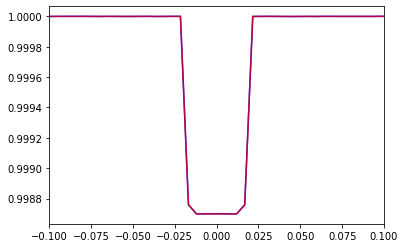

In [475]:
plt.plot(ttime, tflux, c='blue', alpha=1.0)
plt.plot(time, fit, c='red', alpha=0.7)
#plt.plot(time, orig_e0, c='green', alpha=0.7)
plt.xlim(-0.1, 0.1)

Note 2/2/2021: The transit fitting is not accurate enough to produce the correct g (see plot below).

I think the way to fix this is to put an a/Rs prior, given that e must = 0, into the transit fitter.

Don't know what that will be yet.

In [476]:
T14 = ph.get_T14(p_f, rprs_f, a_f, i_f)
T14err = 0.0001*86400

T23 = ph.get_T23(p_f, rprs_f, a_f, i_f)
T23err = 0.0001*86400

# $g$

In [477]:
gs_t, rho_c, rho_s_spec, T14s, T23s = ph.get_g_distribution(rho_star, p_f, perr_f, rprs_f, rprserr_f, T14, T14err, T23, T23err)
gs = gs_t

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 100824.62it/s]


In [478]:
g_mean

1.2871827512413305

In [479]:
g_sigma

0.08237204599301784

In [480]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)

In [481]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [482]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:07<00:00, 663.31it/s]


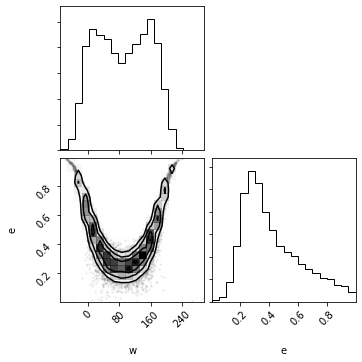

In [483]:
# fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = ["w", "e"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)
#     ax.set_xlim(0, 500)

# axes[-1].set_xlabel("step number");

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)